In [1]:
options(warn=-1)
install.packages('GGally')
install.packages('devtools')
devtools::install_github('vqv/ggbiplot')

library(tidyverse)
library(GGally)
library(ggbiplot)



Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Skipping install of 'ggbiplot' from a github remote, the SHA1 (7325e880) has not changed since last install.
  Use `force = TRUE` to force installation
Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

Loading required package: plyr
------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
-------------------------

### Load Data

In [2]:
cnames <- c('id',
           'clump_thick',
           'unif_size',
           'unif_shape',
           'marg_adhesion',
           'epith_size',
           'bare_nuclei',
           'bland_chromatin',
           'norm_nucleoli',
           'mitoses',
           'class')


df <- read_csv('bc_data.csv',col_names=cnames) %>%
mutate(bare_nuclei = as.numeric(bare_nuclei),
      cancer = as.numeric(class==4)) %>%
select(-class)


Parsed with column specification:
cols(
  id = col_integer(),
  clump_thick = col_integer(),
  unif_size = col_integer(),
  unif_shape = col_integer(),
  marg_adhesion = col_integer(),
  epith_size = col_integer(),
  bare_nuclei = col_character(),
  bland_chromatin = col_integer(),
  norm_nucleoli = col_integer(),
  mitoses = col_integer(),
  class = col_integer()
)


#### Proportion of Cancerous Cells

In [3]:
mean(df$cancer)

[1] 0.3447783

#### Correlation Structure
Look at the distributions and correlations among the different features

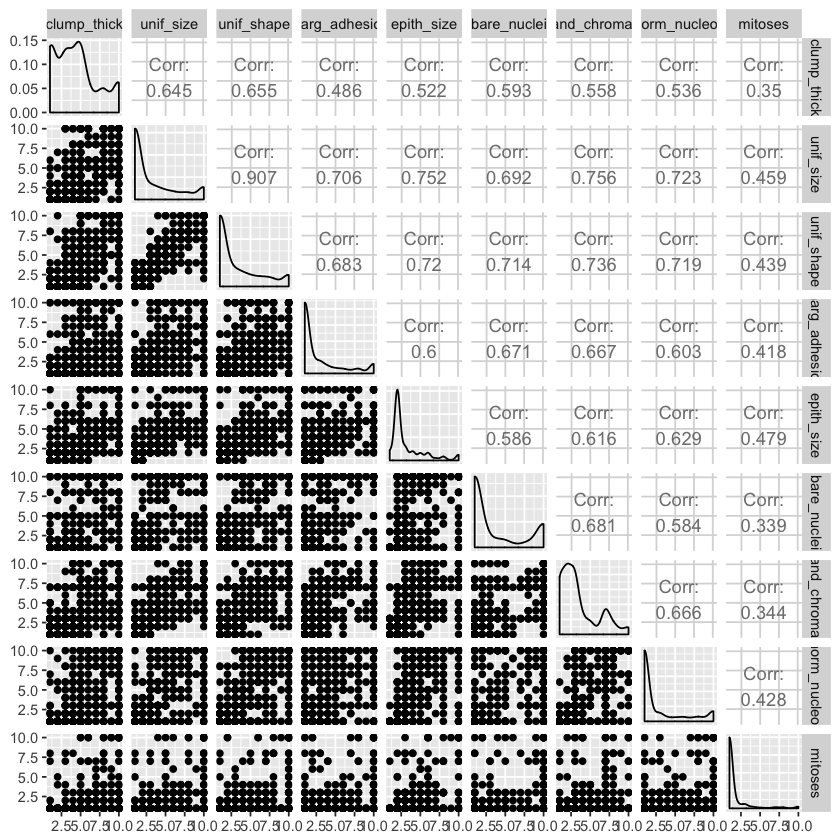

In [4]:
ggpairs(select(df,-id,-cancer))

#### Visualizing Distributions across Benign and Malignant Cells
It looks like the benign cells generally have a very restricted range across all columns, whereas cancerous cells do not. 

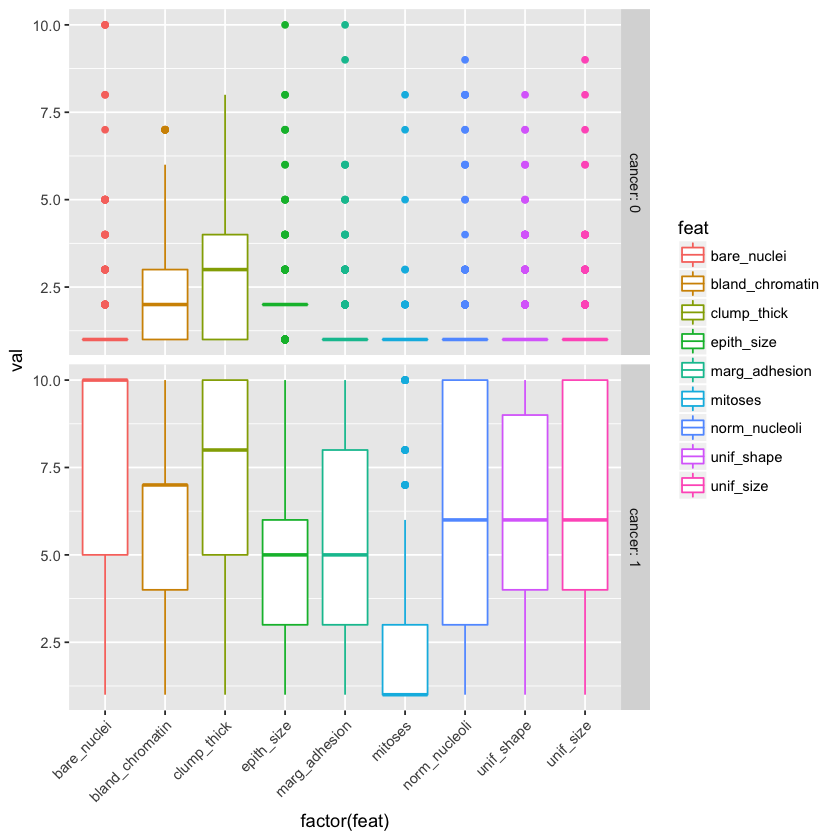

In [5]:

df_long <- df %>%
gather(feat,val,clump_thick:mitoses)


ggplot(data=df_long, aes(x=factor(feat),y=val,group=feat,color=feat)) + geom_boxplot() + facet_grid(cancer ~.,labeller=label_both) +
theme(axis.text.x = element_text(angle = 45, hjust = 1))



Checking for missing data. Only the `bare_nuclei` column has a few missing values. For simplicity, we just exclude these rows

In [6]:
#checking missing values
miss <- df_long %>%
group_by(feat)  %>%
summarise(sum(is.na(val)))

miss

sum(is.na(val))
16


### Dimension Reduction

Since features are pretty highly correlated, let's look at PCA for easier visualization. It looks like 2 components are sufficient to explain a good portion of the variance (74%) but we would want 4 to explain 85%. 

Importance of components:
                          PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     2.4289 0.88088 0.73434 0.67796 0.61667 0.54943 0.54259
Proportion of Variance 0.6555 0.08622 0.05992 0.05107 0.04225 0.03354 0.03271
Cumulative Proportion  0.6555 0.74172 0.80163 0.85270 0.89496 0.92850 0.96121
                           PC8     PC9
Standard deviation     0.51062 0.29729
Proportion of Variance 0.02897 0.00982
Cumulative Proportion  0.99018 1.00000

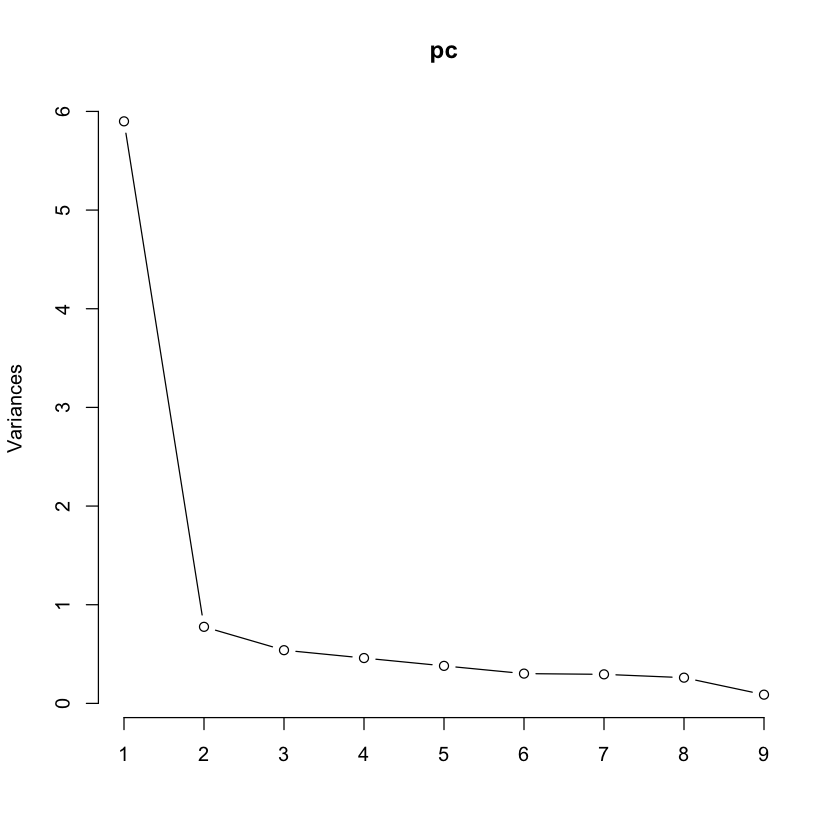

In [7]:
dat <- select(df,-id,-cancer) %>%
filter(!is.na(bare_nuclei))

pc <- prcomp(dat,scale=T,center=T)
plot(pc, type = "l")
summary(pc)

#### BiPlot of PCA loadings

We can see that the benign cells are pretty clearly distinguished with the first 2 principal components.

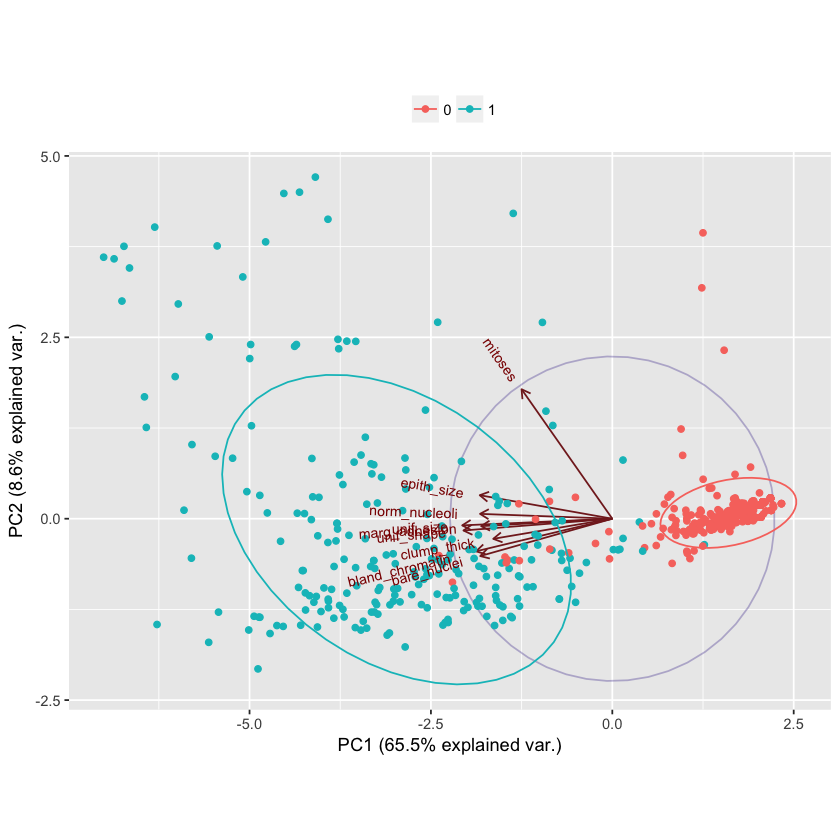

In [8]:
library(ggbiplot)
cancer <- factor(df$cancer[!is.na(df$bare_nuclei)])

g <- ggbiplot(pc, obs.scale = 1, var.scale = 1, ellipse = TRUE, groups = cancer,
              circle = TRUE)
g <- g + scale_color_discrete(name = '')
g <- g + theme(legend.direction = 'horizontal', 
               legend.position = 'top')
print(g)

Visualization of the different features within a unit circle. This shows that everything but the `mitosis` feature is pretty highly correlated with each other

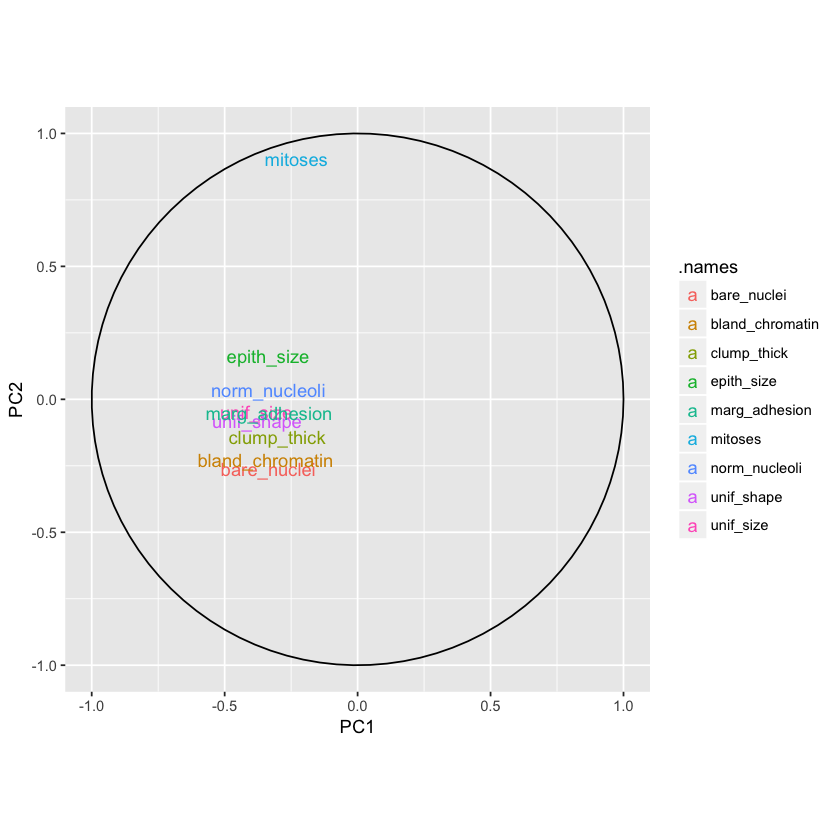

In [9]:
theta <- seq(0,2*pi,length.out = 100)
circle <- data.frame(x = cos(theta), y = sin(theta))
p <- ggplot(circle,aes(x,y)) + geom_path()

loadings <- data.frame(pc$rotation, 
                       .names = row.names(pc$rotation))
p + geom_text(data=loadings, 
              mapping=aes(x = PC1, y = PC2, label = .names, colour = .names)) +
  coord_fixed(ratio=1) +
  labs(x = "PC1", y = "PC2")

Running PCA with the `caret` package, which allows easy Box-Cox transformation of the data. Looking at the loading plot we see an even clearer distinction.

In [10]:
library(caret)
trans = preProcess(as.matrix(dat), 
                   method=c("BoxCox", "center", 
                            "scale", "pca"))
PC = predict(trans, as.matrix(dat))

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



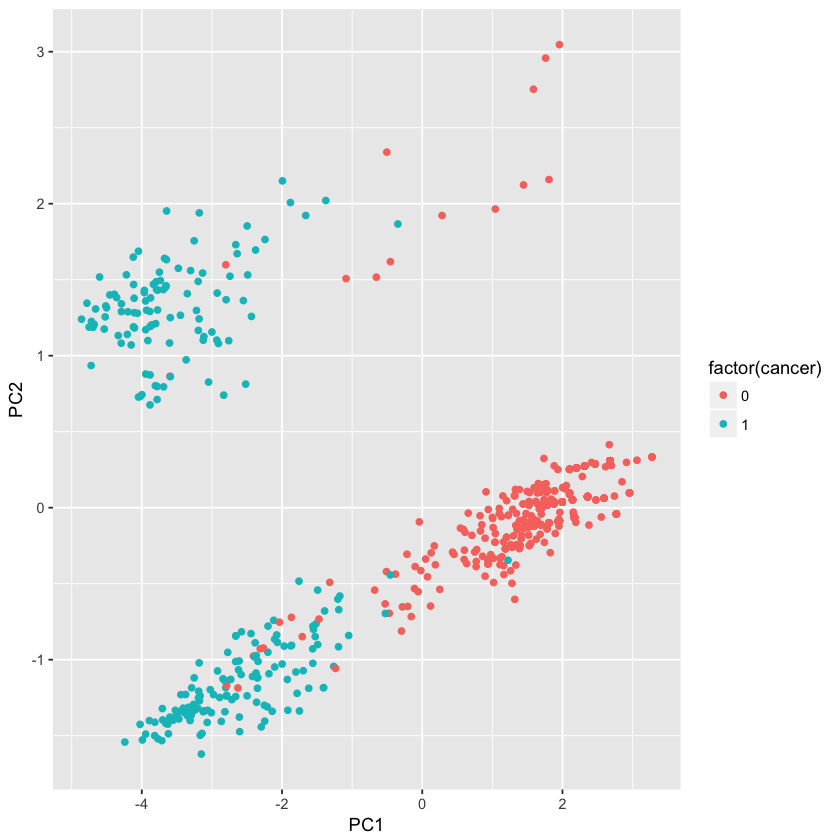

In [11]:
ggplot(as.data.frame(PC), aes(x=PC1,y=PC2,color=factor(cancer))) + geom_point()

### Multidimensional Scaling

Just another way to capture the relationships with plotting. This tells a similar story as before. 

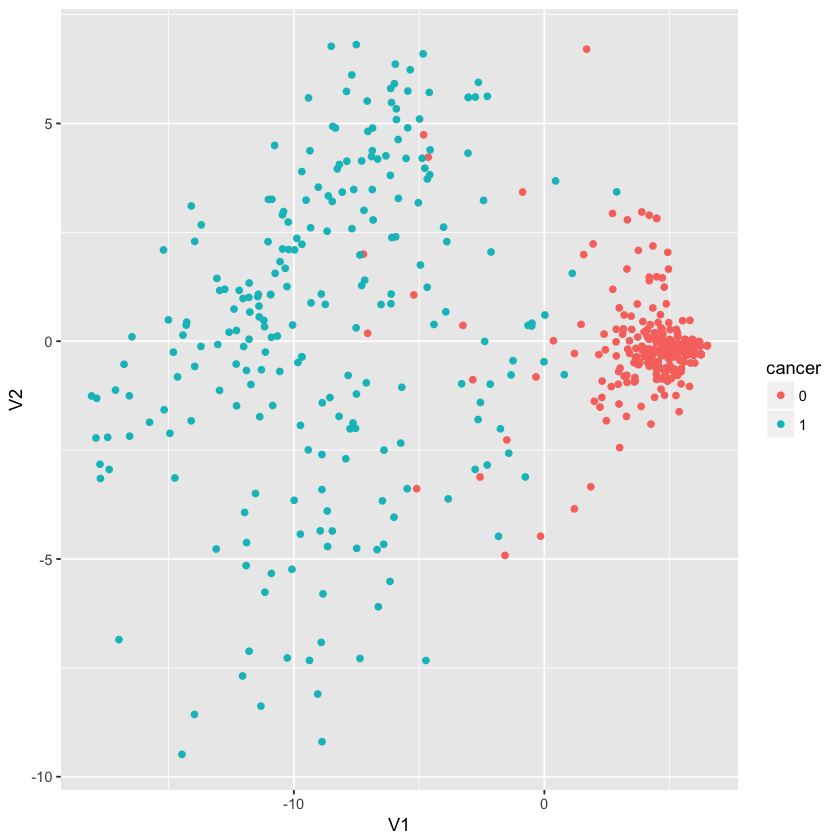

In [12]:
d <- dist(dat) # euclidean distances between the rows
fit <- cmdscale(d,eig=TRUE, k=2) # k is the number of dim


mds <- as.data.frame(fit$points)
mds$cancer <- cancer

ggplot(mds, aes(x=V1,y=V2,group = cancer, color=cancer)) + geom_point()

Write the data so we can easily load for modeling

In [13]:
write_csv(df,'bc_data_clean.csv')